In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hadisahrul","key":"201dbec0f51f7230fd5b3ac159865f9a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d joebeachcapital/realwaste

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 650M/657M [00:06<00:00, 64.5MB/s]
100% 657M/657M [00:06<00:00, 100MB/s] 


In [ ]:
!mkdir realwaste
!unzip realwaste.zip -d data
!ls data

Archive:  realwaste.zip
  inflating: data/realwaste-main/README.md  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_10.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_100.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_101.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_102.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_103.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_104.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_105.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_106.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_107.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_108.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardboard_109.jpg  
  inflating: data/realwaste-main/RealWaste/Cardboard/Cardb

In [ ]:
import os
import cv2
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
import time

# Configuration
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
TEST_SPLIT = 0.1
VAL_SPLIT = 0.1
RANDOM_SEED = 42
DATA_DIR = '/content/data/realwaste-main/RealWaste'

class RealWasteDataset(Dataset):
    def __init__(self, root_dir=None, data=[], labels=[], size=None, transforms=[], transform=None, print_info=True):
        self.root_dir = root_dir
        self.transforms = transforms
        self.transform = transform
        self.data = data
        self.labels = labels
        self.image_sizes = {} if size is None else {size} # Dictionary to store image size counts

        # Class mapping
        self.classes = {
            0: 'Cardboard',
            1: 'Food Organics',
            2: 'Glass',
            3: 'Metal',
            4: 'Miscellaneous Trash',
            5: 'Paper',
            6: 'Plastic',
            7: 'Textile Trash',
            8: 'Vegetation'
        }

        start = time.time()

        if root_dir is not None:

            for label, label_name in self.classes.items():
                class_dir = os.path.join(self.root_dir, label_name)
                if not os.path.exists(class_dir):
                    continue
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)

                    try:
                        with Image.open(img_path) as img:
                            img.verify()  # Verifies the file integrity without loading the full image
                            img_size = img.size  # Access metadata
                            self.image_sizes[img_size] = self.image_sizes.get(img_size, 0) + 1
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                        continue

                    self.data.append(img_path)
                    self.labels.append(label)

        end = time.time()

        if print_info:
            self.print_info(round(end - start, 2))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")  # Ensures the image has 3 channels (RGB)

        if self.transforms:
            image = self.transforms[idx](image)
        elif self.transform:
            image = self.transform(image)

        return image, label

    def to_dataframe(self):
        return pd.DataFrame({
            'image_path': self.data,
            'label': self.labels,
            'transformation': [self.transform for _ in range(len(self.labels))]
        })

        return image, label

    def print_info(self, elapsed):
        print("----------Dataset Summary----------")
        print(f"Total images: {len(self.data)}")
        print(f"Number of classes: {len(self.classes)}")
        print("Images per class:")

        class_counts = {label_name: 0 for label_name in self.classes.values()}
        for label in self.labels:
            class_name = self.classes[label]
            class_counts[class_name] += 1

        for class_name, count in class_counts.items():
            print(f"  {class_name}: {count} images")

        print("\nUnique image sizes:")
        for size, count in self.image_sizes.items():
            print(f"  {size}: {count} images")

        print(f"\nLoaded in {elapsed} seconds!")

transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
])

full_dataset = RealWasteDataset(DATA_DIR, transform=transform)

----------Dataset Summary----------
Total images: 4752
Number of classes: 9
Images per class:
  Cardboard: 461 images
  Food Organics: 411 images
  Glass: 420 images
  Metal: 790 images
  Miscellaneous Trash: 495 images
  Paper: 500 images
  Plastic: 921 images
  Textile Trash: 318 images
  Vegetation: 436 images

Unique image sizes:
  (524, 524): 4752 images

Loaded in 0.49 seconds!


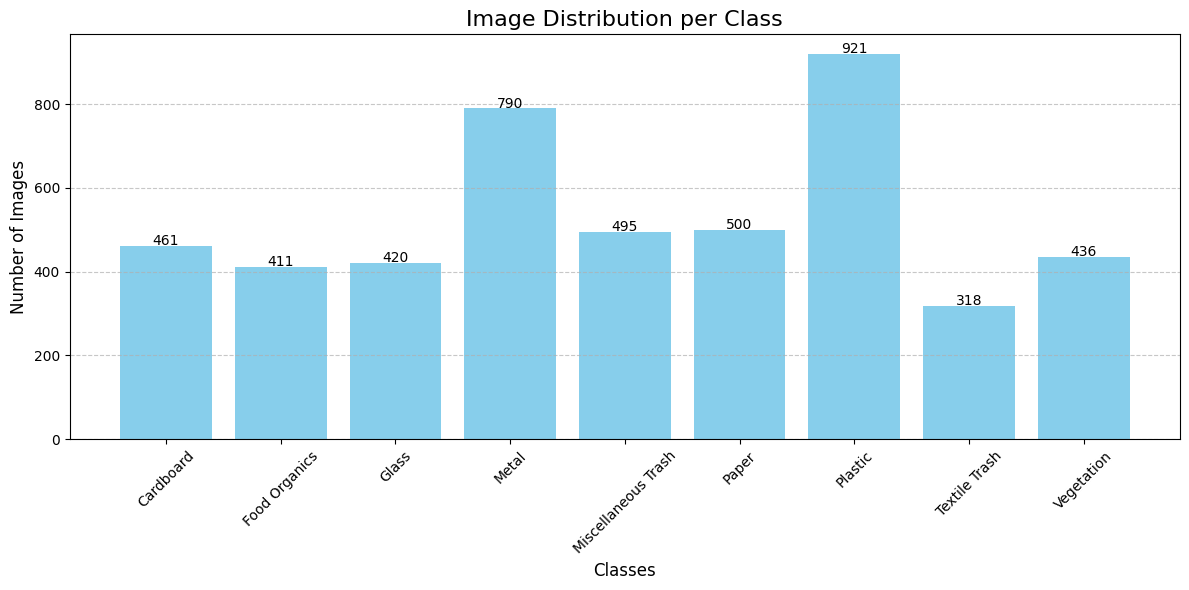

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution_from_dataframe(dataframe, label_to_class, title="Image Distribution per Class", color='skyblue'):

    # Count the number of images per class
    label_counts = Counter(dataframe['label'])

    # Sort classes based on their numeric labels
    sorted_labels = sorted(label_counts.items())

    # Create the bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        [label_to_class[label] for label, _ in sorted_labels],  # Class names
        [count for _, count in sorted_labels],  # Counts
        color=color
    )

    # Add count labels above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, str(yval), ha='center', fontsize=10, color='black')

    # Add titles and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the chart
    plt.tight_layout()
    plt.show()

# Assume 'df' is a pandas DataFrame with a column 'label'
# and 'label_to_class' is a dictionary mapping labels to class names.
plot_class_distribution_from_dataframe(full_dataset.to_dataframe(), full_dataset.classes, title="Image Distribution per Class")

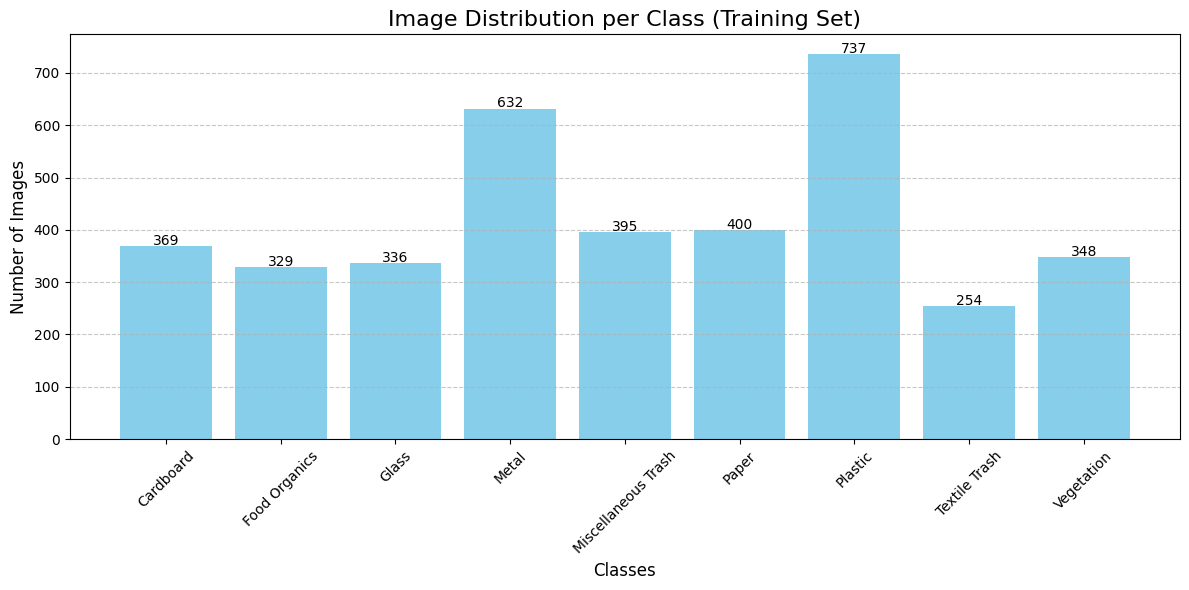

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_val_test_split(full_dataframe, test_size, val_size, random_seed=42):
    # StratifiedShuffleSplit for train-test split
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_seed)
    for train_val_idx, test_idx in stratified_split.split(full_dataframe, full_dataframe['label']):
        train_val_df = full_dataframe.iloc[train_val_idx]
        test_df = full_dataframe.iloc[test_idx]

    # Calculate the adjusted validation size relative to the remaining data
    val_adjusted_size = val_size / (1 - test_size)

    # StratifiedShuffleSplit for train-validation split
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_adjusted_size, random_state=random_seed)
    for train_idx, val_idx in stratified_split.split(train_val_df, train_val_df['label']):
        train_df = train_val_df.iloc[train_idx]
        val_df = train_val_df.iloc[val_idx]

    return train_df, val_df, test_df

# Assume full_dataset is an instance of RealWasteDataset
train_df, val_df, test_df = train_val_test_split(full_dataset.to_dataframe(), test_size=TEST_SPLIT, val_size=VAL_SPLIT)

# Plot train data
plot_class_distribution_from_dataframe(train_df, full_dataset.classes, title="Image Distribution per Class (Training Set)")

Augmenting Images: 100%|██████████| 3800/3800 [00:00<00:00, 21857.59it/s]


Number of images in the original dataset: 3800
Number of images in the augmented dataset: 15200


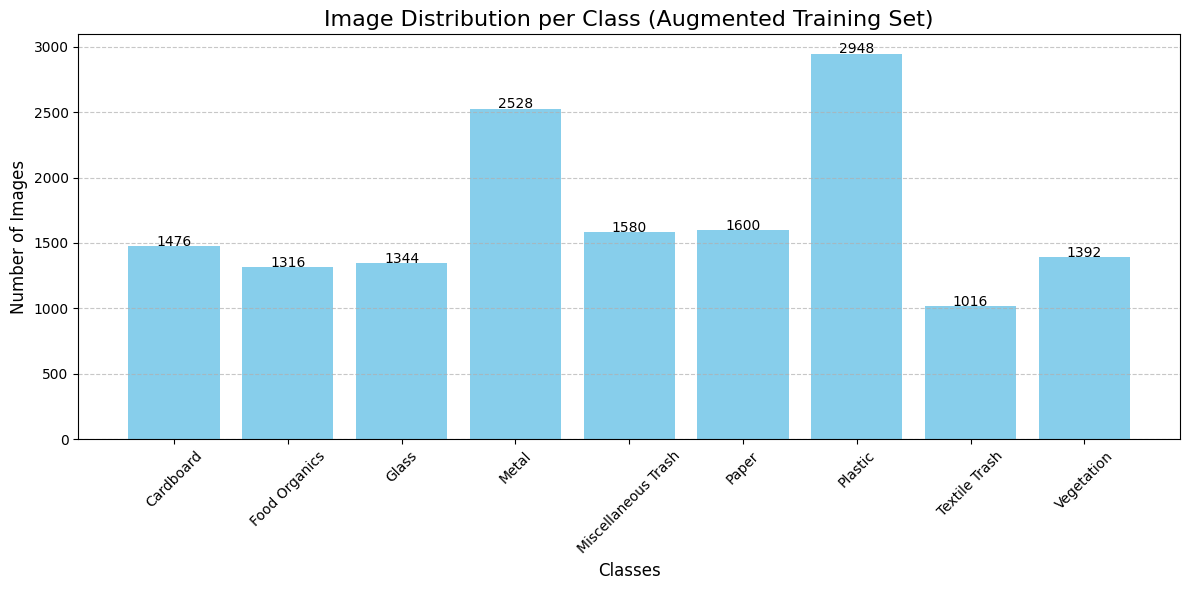

In [ ]:
from tqdm import tqdm

def augment_train(train_df, duplication_factor):
    # Define the augmentation pipeline
    transform_augment = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=45),
        transforms.RandomResizedCrop(size=IMG_SIZE[0], scale=(0.6, 0.9)),
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor()
    ])

    augmented_rows = []

    # Add progress bar for the outer loop
    for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Augmenting Images"):
        img_path, label = row['image_path'], row['label']

        # Generate `x` augmented transformations
        for _ in range(duplication_factor):
            augmented_rows.append({
                "image_path": img_path,  # Use the same image path
                "label": label,         # Keep the label unchanged
                "transformation": transform_augment  # Store the transformation object
            })

    # Create a DataFrame from the augmented rows
    augmented_df = pd.DataFrame(augmented_rows)

    # Concatenate the original and augmented DataFrames
    combined_df = pd.concat([train_df, augmented_df], ignore_index=True)

    return combined_df


# Apply data augmentation to the train dataset
train_df_augmented = augment_train(train_df, duplication_factor=3)

# Verify the number of images
print(f"Number of images in the original dataset: {len(train_df)}")
print(f"Number of images in the augmented dataset: {len(train_df_augmented)}")

# Plot the augmented data
plot_class_distribution_from_dataframe(train_df_augmented, full_dataset.classes, title="Image Distribution per Class (Augmented Training Set)")

Sampling images by class...


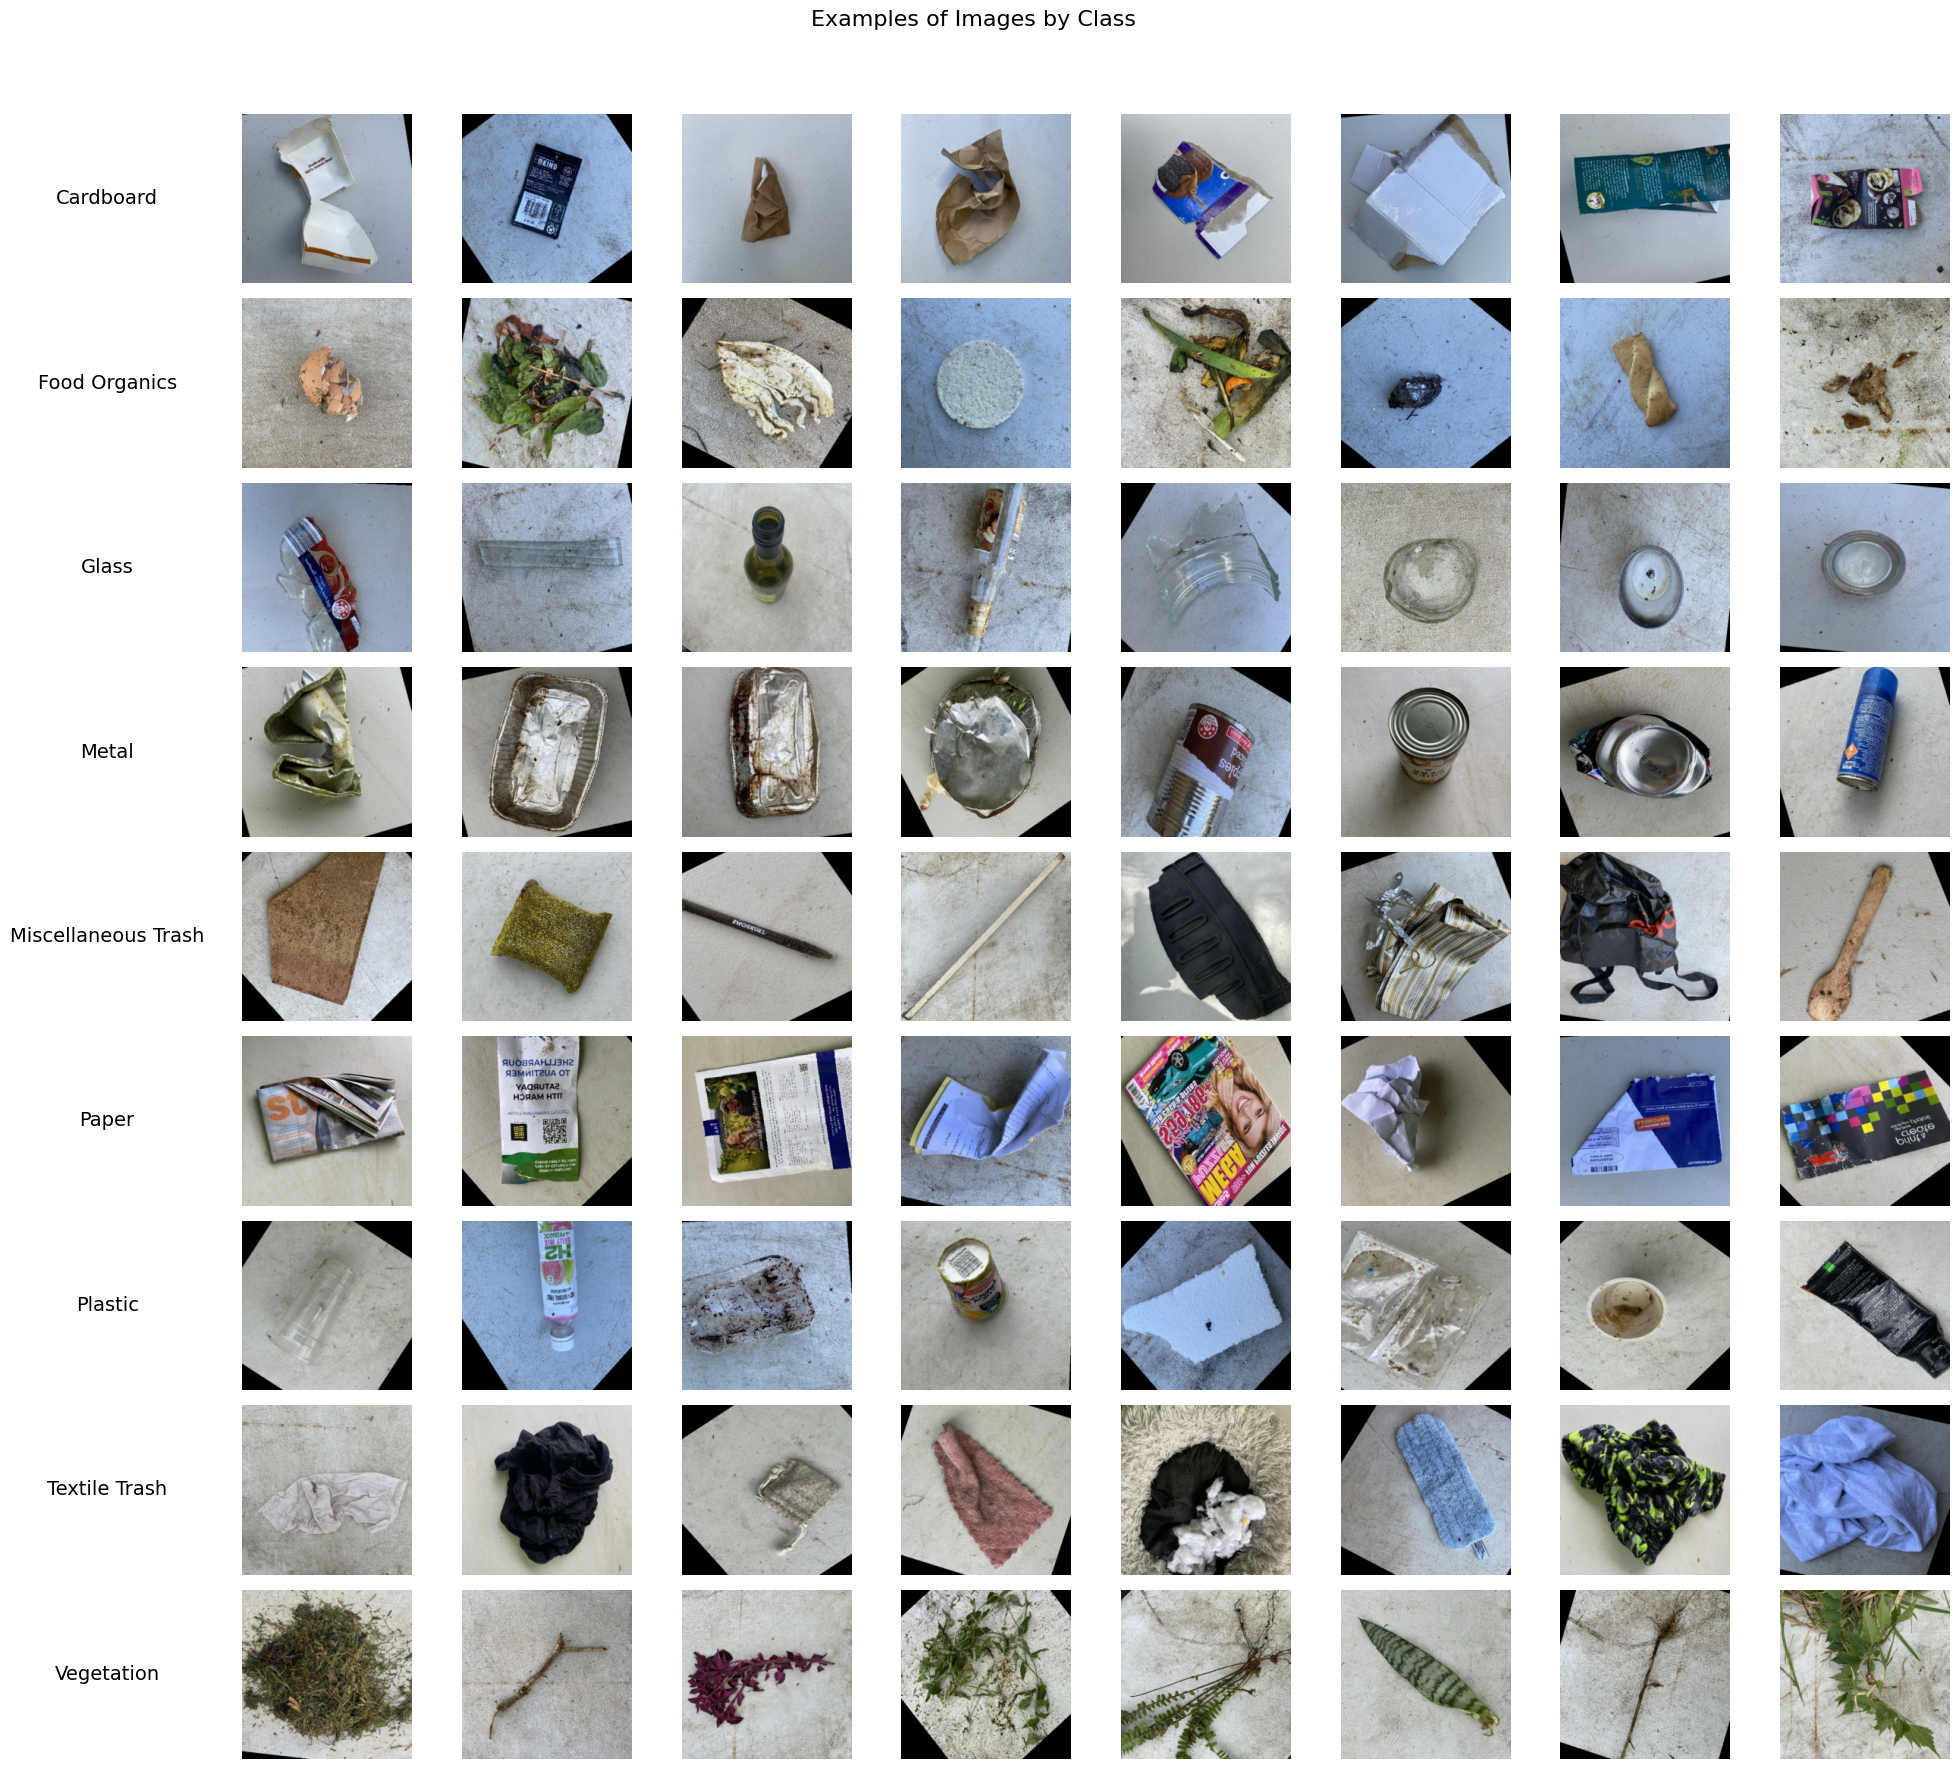

In [ ]:
from collections import defaultdict

def plot_training_images_by_class(train_df_augmented, class_names, ncols=5, title="Examples of Images by Class"):

    # Group and sample images by class
    print("Sampling images by class...")
    sampled_images = defaultdict(list)

    for label in train_df_augmented['label'].unique():
        # Filter the DataFrame for the current class and sample up to `ncols` rows
        class_df = train_df_augmented[train_df_augmented['label'] == label]
        sampled_df = class_df.sample(min(len(class_df), ncols))

        for _, row in sampled_df.iterrows():
            sampled_images[label].append(row)

    # Determine the number of classes
    classes = sorted(sampled_images.keys())
    nrows = len(classes)  # One row per class

    # Configure the plot with a column for class names
    fig, axs = plt.subplots(nrows, ncols + 1, figsize=(ncols * 2.5, nrows * 2))  # +1 for class name column
    fig.suptitle(title, fontsize=16)

    for i, class_label in enumerate(classes):
        # Get the class name using the class_names dictionary
        class_name = class_names[class_label]

        # Add the class name in the first column
        axs[i, 0].text(0.5, 0.5, class_name, fontsize=14, ha="center", va="center")
        axs[i, 0].axis('off')

        # Display sampled images
        for j, row in enumerate(sampled_images[class_label]):
            img_path = row['image_path']
            transform = row['transformation']

            try:
                with Image.open(img_path).convert("RGB") as img:
                    # Apply transformation if present
                    if transform:
                        img = transform(img)
                    # Convert to NumPy array
                    if isinstance(img, torch.Tensor):
                        img = img.permute(1, 2, 0).numpy()  # Convert Tensor (C, H, W) to NumPy (H, W, C)
                        img = (img * 255).astype("uint8")  # Convert to 8-bit for visualization
                    else:
                        img = np.array(img)
                    axs[i, j + 1].imshow(img)
                    axs[i, j + 1].axis('off')
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                axs[i, j + 1].axis('off')

    # Adjust the layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Display images organized by class with class names at the beginning of each row
plot_training_images_by_class(train_df_augmented, full_dataset.classes, ncols=8, title="Examples of Images by Class")

In [ ]:
# Load the TSV files into DataFrames
#train_df_augmented = pd.read_csv('train_df_augmented.tsv', sep='\t')
#val_df = pd.read_csv('val_df.tsv', sep='\t')
#test_df = pd.read_csv('test_df.tsv', sep='\t')

#print("DataFrames have been loaded from TSV files.")

train_dataset = RealWasteDataset(
    data=train_df_augmented['image_path'].to_list(),
    labels=train_df_augmented['label'].to_list(),
    transforms=train_df_augmented['transformation'].to_list(),
    print_info=False
)

val_dataset = RealWasteDataset(
    data=val_df['image_path'].to_list(),
    labels=val_df['label'].to_list(),
    transforms=val_df['transformation'].to_list(),
    print_info=False
)

test_dataset = RealWasteDataset(
    data=test_df['image_path'].to_list(),
    labels=test_df['label'].to_list(),
    transforms=test_df['transformation'].to_list(),
    print_info=False
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# Print dataset information
print("Train", end='\n\t')
print(f"Batches: {len(train_loader)}", end='\n\t')
print(f"Images: {len(train_loader.dataset)}")
print("Validation", end='\n\t')
print(f"Batches: {len(val_loader)}", end='\n\t')
print(f"Images: {len(val_loader.dataset)}")
print("Test", end='\n\t')
print(f"Batches: {len(test_loader)}", end='\n\t')
print(f"Images: {len(test_loader.dataset)}")

Train
	Batches: 238
	Images: 15200
Validation
	Batches: 8
	Images: 476
Test
	Batches: 8
	Images: 476


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create the class weights
class_counts = np.bincount(train_dataset.labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
num_classes = len(full_dataset.classes)

# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update the training results dataframe
def update_training_results_csv(model_name, optimizer, lr, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies):

    csv_path = 'training_results.csv'

    # Controlla se il file CSV esiste
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # Se non esiste, crea un DataFrame vuoto con le colonne necessarie
        df = pd.DataFrame(columns=["model_name",
                                   "epoch",
                                   "optimizer",
                                   "learning_rate",
                                   "weight_decay",
                                   "train_loss",
                                   "val_loss",
                                   "train_accuracy",
                                   "val_accuracy"
                                  ]
                         )

    # Rimuovi eventuali vecchie entry per il modello
    df = df[df['model_name'] != model_name]

    # Crea un nuovo DataFrame con i risultati attuali
    new_entries = {
        "model_name": [model_name] * len(train_losses),
        "epoch": list(range(1, len(train_losses) + 1)),
        "optimizer": [optimizer] * len(train_losses),
        "learning_rate": [lr] * len(train_losses),
        "weight_decay": [weight_decay] * len(train_losses),
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_accuracy": train_accuracies,
        "val_accuracy": val_accuracies
    }

    new_df = pd.DataFrame(new_entries)

    # Concatenare i nuovi dati con quelli esistenti
    df = pd.concat([df, new_df], ignore_index=True)

    # Salva il DataFrame aggiornato nel file CSV
    df.to_csv(csv_path, index=False)

    print(f"Dati di training per '{model_name}' aggiornati in '{csv_path}'")

# Function to train the model with a progress bar
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Progress bar for training
        with tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass through the model
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backpropagation
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Update the progress bar
                tepoch.set_postfix(loss=running_loss / len(tepoch), accuracy=100 * correct_train / total_train)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Progress bar for validation
        with tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit="batch") as vepoch:
            with torch.no_grad():
                for images, labels in vepoch:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

                    # Update the progress bar
                    vepoch.set_postfix(loss=val_loss / len(vepoch), accuracy=100 * correct_val / total_val)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Useful plot function
def plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]
Validation Epoch 1/6: 100%|██████████| 8/8 [00:04<00:00,  1.98batch/s, accuracy=66, loss=1.4]


Epoch 1/6, Train Loss: 1.9157, Train Accuracy: 41.78%, Val Loss: 1.3971, Val Accuracy: 65.97%


Validation Epoch 2/6: 100%|██████████| 8/8 [00:04<00:00,  1.98batch/s, accuracy=79.8, loss=0.624]


Epoch 2/6, Train Loss: 0.9589, Train Accuracy: 74.03%, Val Loss: 0.6238, Val Accuracy: 79.83%


Validation Epoch 3/6: 100%|██████████| 8/8 [00:04<00:00,  1.63batch/s, accuracy=87.2, loss=0.394]


Epoch 3/6, Train Loss: 0.5029, Train Accuracy: 84.05%, Val Loss: 0.3939, Val Accuracy: 87.18%


Validation Epoch 4/6: 100%|██████████| 8/8 [00:04<00:00,  1.98batch/s, accuracy=89.3, loss=0.301]


Epoch 4/6, Train Loss: 0.3086, Train Accuracy: 89.94%, Val Loss: 0.3012, Val Accuracy: 89.29%


Validation Epoch 5/6: 100%|██████████| 8/8 [00:04<00:00,  1.65batch/s, accuracy=89.9, loss=0.272]


Epoch 5/6, Train Loss: 0.1988, Train Accuracy: 93.60%, Val Loss: 0.2724, Val Accuracy: 89.92%


Validation Epoch 6/6: 100%|██████████| 8/8 [00:04<00:00,  1.96batch/s, accuracy=91.4, loss=0.231]
<ipython-input-11-75fae535d393>:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


Epoch 6/6, Train Loss: 0.1387, Train Accuracy: 95.74%, Val Loss: 0.2314, Val Accuracy: 91.39%
Model saved to /content/modelResNet50_model.pth
Dati di training per 'ResNet50' aggiornati in 'training_results.csv'


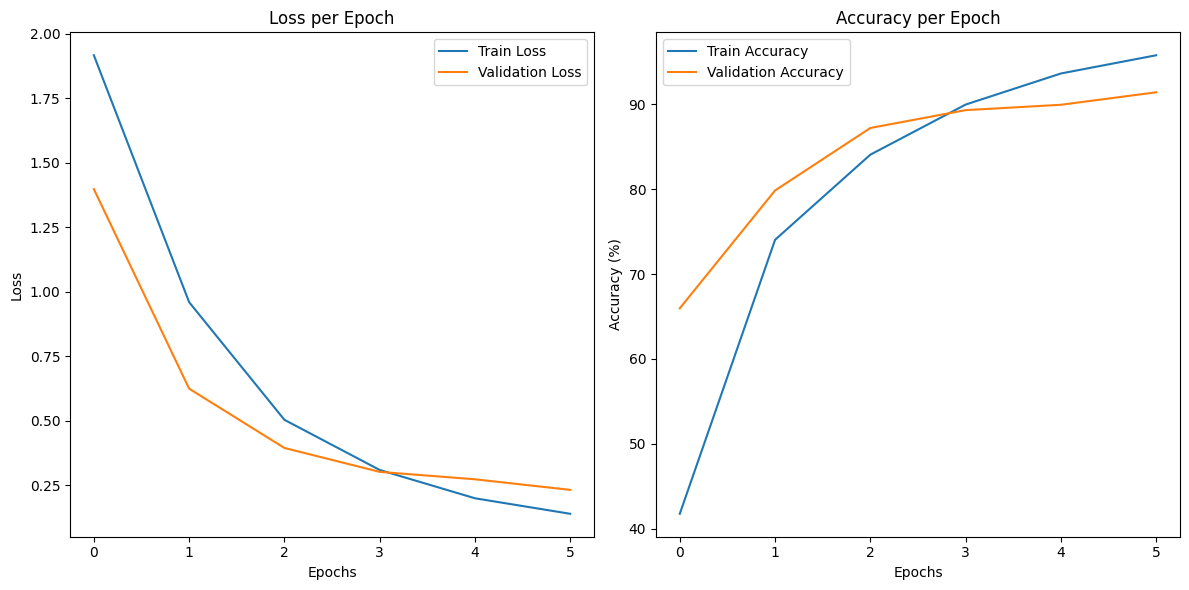

In [ ]:
from torchvision.models import ResNet50_Weights

# Carica il modello
model_name = "ResNet50"
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.fc.parameters():
    param.requires_grad = True

# Sposta il modello su GPU, se disponibile
model = model.to(device)

# Funzione di perdita e ottimizzatore
weights = torch.tensor(class_weights.copy(), dtype=torch.float32).to(device)  # Personalizza i pesi
criterion = nn.CrossEntropyLoss(weight=weights)
learning_rate = 1e-5
weight_decay = 1e-2
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Avvia il training
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=6
)

# Salva il modello
model_save_path = f"/content/model{model_name}_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Update metrics dataset
update_training_results_csv(model_name, "adam", learning_rate, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies)

# Plot delle metriche
plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

<ipython-input-44-8f07c0cf3a96>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Saving download.jpg to download.jpg


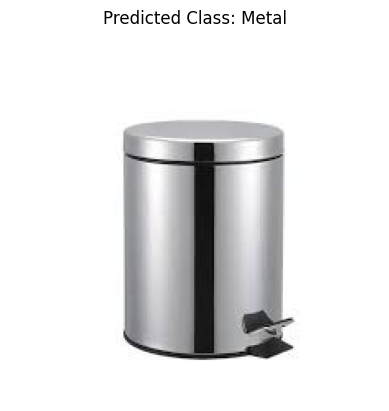

The predicted class is: Metal


In [ ]:
# prompt: buatkan tes klasifikasinya dengan input gambar

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
model_name = "ResNet50"
model_save_path = f"/content/model{model_name}_model.pth"
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_classes = len(full_dataset.classes) # Assuming full_dataset is defined in your previous code
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_save_path))
model.eval()
model.to(device)  # Move model to the correct device

# Define image transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize the image
    transforms.ToTensor(),         # Convert to tensor
])

def classify_image(image_path):
    try:
        # Open the image
        img = Image.open(image_path).convert("RGB")
        # Apply the same transformations used for training
        img_tensor = transform(img).unsqueeze(0)  # Add a batch dimension
        img_tensor = img_tensor.to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted = torch.max(outputs, 1)

        # Get the predicted class
        predicted_class = predicted.item()
        predicted_class_name = full_dataset.classes[predicted_class]  # Assuming you have defined full_dataset.classes

        # Display the image and prediction
        plt.imshow(np.array(img))
        plt.title(f"Predicted Class: {predicted_class_name}")
        plt.axis("off")
        plt.show()

        print(f"The predicted class is: {predicted_class_name}")

    except Exception as e:
        print(f"Error during classification: {e}")


# Example usage:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
classify_image(image_path)